# Group 12, DDDML

# Outline
A distributed, decentralized machine learning framework.

1. Introduction to core Algorithms
2. Distributed ML
3. Decentralized ML
4. Security of Decentralized ML

Join the network to mine some money: https://github.com/jzh18/NeedleDDD/blob/main/final_project_report.ipynb
1. Create an account and start a Miner on your local machine:
```
# For arm64 (mostly Mac)
$ IMG=hfzhang6/pouw-geth-client:miner-mac-m1

# For amd64 (mostly Windows)
$ IMG=hfzhang6/pouw-geth-client:miner-amd64

$ docker pull $IMG

$ docker run -it --name account-generator --entrypoint=""  $IMG geth account new
```
2. This will output something like:
```
Your new account is locked with a password. Please give a password. Do not forget this password.
Password:
Repeat password:

Your new key was generated

Public address of the key:   0x2ed1D3e06f268Dd207dab9f3F452252348d0eb57
Path of the secret key file: /root/.ethereum/keystore/UTC--2024-12-14T08-01-18.629899881Z--2ed1d3e06f268dd207dab9f3f452252348d0eb57

- You can share your public address with anyone. Others need it to interact with you.
- You must NEVER share the secret key with anyone! The key controls access to your funds!
- You must BACKUP your key file! Without the key, it's impossible to access account funds!
- You must REMEMBER your password! Without the password, it's impossible to decrypt the key!
```
3. The public address is your account address. Replace the following MINER_ADDRESS with your account address and run the following command:
```
$ docker run -it --name my-miner -p 8545:8545 -p 30303:30303  -e MINER_ADDRESS=0x2ed1D3e06f268Dd207dab9f3F452252348d0eb57 $IMG
```

# 1 Core Algorithms
## 1.1 Introduction to Autodiff
Automatic differentiation (autodiff) is a computational technique to evaluate derivatives of functions efficiently and accurately. Unlike numerical differentiation, which approximates derivatives, or symbolic differentiation, which manipulates equations algebraically, autodiff uses the chain rule systematically to compute derivatives programmatically. It is extensively used in machine learning for optimization tasks, such as training neural networks.

### 1.1.1 How Autodiff Works
Autodiff operates in two main modes:
1. **Forward Mode**:
   - Tracks derivatives as the computation progresses from inputs to outputs.
   - Efficient for functions with fewer inputs and more outputs.
   - Example: Computing gradients for scalar-valued loss functions.

2. **Reverse Mode**:
   - Computes derivatives by propagating from outputs to inputs.
   - Efficient for functions with many inputs and a single output, like neural network training.
   - Example: Backpropagation for deep learning models.

In both modes, autodiff builds a computational graph representing the operations and systematically applies the chain rule to calculate derivatives.

### 1.1.2 Role of Autodiff in Our Project
In our project, autodiff was a crucial component for:
- **Training Neural Networks**: Calculating gradients for loss functions during backpropagation.
- **Optimization**: Enabling efficient parameter updates using gradient-based optimizers like SGD or Adam.

For instance, we used autodiff to compute gradients of the loss function with respect to model parameters, ensuring accurate updates in each iteration. This capability streamlined our implementation, allowing us to focus on model design and evaluation.

### 1.1.3 Benefits of Using Autodiff in the Project
- **Accuracy**: Eliminates errors common in numerical differentiation (e.g., rounding errors).
- **Efficiency**: Automatically computes gradients without the need for manual derivation or coding.
- **Flexibility**: Handles complex, multi-layered models with ease.
These benefits were evident in the training phase of our project, where autodiff enabled rapid experimentation with different model architectures and optimization strategies.


### 1.1.4 Conclusion and Takeaway
Autodiff significantly enhanced the computational efficiency and accuracy of our project, especially in training and optimizing our machine learning models. Its seamless integration into our workflow highlighted its importance in modern machine learning pipelines. As a future direction, we plan to explore advanced autodiff frameworks to further improve scalability and efficiency for larger datasets and models.

## 1.2 Introduction to GEMM
### 1.2.1 What is GEMM?
GEMM, short for General Matrix to Matrix Multiplication, is a key algorithm in the Basic Linear Algebra Subprograms (BLAS) library, designed to perform matrix multiplications of the form:

$$C = \alpha \cdot A \cdot B + \beta \cdot C $$

where:
- $A$, $B$, and $C$ are matrices.
- $ \alpha $ and $\beta$ are scalars.

GEMM is optimized for high performance and is widely used in scientific computing, numerical linear algebra, and machine learning tasks.

### 1.2.2 How GEMM Works
GEMM breaks down matrix multiplication into smaller, cache-friendly operations, taking advantage of hardware acceleration and parallelism. It achieves efficiency through:
- **Block Multiplication**: Decomposing matrices into submatrices to fit into memory hierarchies.
- **Parallel Execution**: Utilizing multi-core processors or GPUs.
- **Optimized Memory Access**: Minimizing data movement to and from main memory.
### 1.2.3 Role of GEMM in Our Project
In our project, GEMM played a foundational role in:
- **Neural Network Operations**: Computing weighted sums in fully connected layers.
- **Backpropagation**: Multiplying gradients with weight matrices during reverse mode autodiff.
- **Model Training Efficiency**: Leveraging hardware acceleration to speed up matrix multiplications.

For example, when training the neural network, GEMM was used to compute the forward pass efficiently by multiplying input activations with weight matrices. During backpropagation, GEMM facilitated the computation of parameter updates by multiplying gradients with activations. These operations were critical to ensuring the scalability of our model.

### 1.2.4 Benefits of Using GEMM in the Project
- **Performance**: GEMM’s hardware-optimized implementations significantly reduced computation time.
- **Scalability**: Enabled training on large datasets and deep models.
- **Robustness**: Provided consistent and accurate results across different hardware platforms.

### 1.2.5 Conclusion and Takeaway
GEMM was indispensable in our project, powering the core matrix operations needed for efficient neural network training. Its integration ensured that our project benefited from state-of-the-art computational efficiency. As we expand our work, further optimization of GEMM-based routines may unlock additional performance gains, particularly on specialized hardware like GPUs and TPUs.


# 2 Distributed ML

## 2.1 Data Parallelism
### 2.1.1 Theory of Data Parallelism

We implement distributed training based on the Needle framework in our final project. In distributed training, the workload to train a model is split up and shared among multiple devices like GPUs, called nodes. These nodes work in parallel to speed up model training. The two main types of distributed training are data parallelism and model parallelism. In short, data parallelism divides the training data into partitions; model parallelism segments the model into different parts that can run concurrently in different nodes [1]. This project implmements the data parallism apporach. We'll elaborate a bit more about data parallelism in the following sections.

In data parallelism, the training data is divided into partitions, where the number of partitions is equal to the total number of available nodes. The partitions are assigned to the available nodes.
The model is copied in each of these nodes and each nodes operates on its own subset of the partition. Each node calculates the gradients of the model parameters independently. The calculated gradients of the nodes are aggragated to obtain the average gradients. Finally, each node updates the model parameters using the average gradients. 

Here we also give a brief explanation of the mathematical theory of data parallelism. Let $w$ be the parameters of the model; $\frac{\delta{L}}{\delta{w}}$ is the original gradients of the batch of size $n$; $l_i$ is the loss for data point $i$ and $k$ is the number of nodes. Then we have
$$
\frac{\delta{L}}{\delta{w}}=\frac{\delta[\frac{1}{n}\sum_{i=1}^{n}l_i]}{\delta{w}} \\
                              =\frac{1}{n}\sum_{i=1}^{n}\frac{\delta{l_i}}{\delta{w}} \\
                              =\frac{m_1}{n}\frac{\frac{1}{m_1}\sum_{i=1}^{m_1}l_i}{\delta{w}} 
                               +\frac{m_2}{n}\frac{\frac{1}{m_2}\sum_{i=m_1+1}^{m_1+m2}l_i}{\delta{w}}
                               + \dots
                               + \frac{m_k}{n}\frac{\frac{1}{m_k}\sum_{i=m_{k-1}+1}^{m_{k-1}+m_{k}}l_i} {\delta{w}} \\
                              =\frac{m_1}{n}\frac{\delta{l_1}}{\delta{w}}+\frac{m_2}{n}\frac{\delta{l_2}}{\delta{w}}
                              +\dots+\frac{m_k}{n}\frac{\delta{l_k}}{\delta{w}}
$$
where $m_k$ is the number of data points assigned to node $k$, and 
$$
m_1+m_2+\dots+m_{k}=n
$$
If $m_1=m_2=\dots=m_k=\frac{n}{k}$, we have
$$
\frac{\delta{L}}{\delta{w}}=\frac{1}{k}[\frac{\delta{l_1}}{\delta{w}}+\frac{\delta{l_2}}{\delta{w}}+\dots+\frac{\delta{l_k}}{\delta{w}}]
$$
where $\frac{\delta{l_k}}{\delta{w}}$ means the gradients calculated by node $k$ based on the data points $\{m_{k-1}+1,m_{k-1}+2,\dots,m_{k-1}+m_k\}$.
According to the above equation, we could know that the average gradients of all the nodes are equal to the original gradients [2]. 

We have two implementations of distributed trainig, which are based on different communication frameworks, i.e., mpi4py [3] and nccl [4]. We intorduce these two implementations in section 2 and section 3 respectively.

To test distributed training, you need to run this notebook with multiple GPUs. Run  `nvidia-smi` to check how many GPUs are available on your machine. 

In [1]:
!nvidia-smi

Mon Jan  9 11:39:01 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  On   | 00000000:4E:00.0 Off |                    0 |
| N/A   24C    P0    50W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100-SXM...  On   | 00000000:B7:00.0 Off |                    0 |
| N/A   

Clone the cod and install necessary packages:

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')
# %cd /content/drive/MyDrive/

# !git clone https://github.com/jzh18/hw4.git
# !pip3 install --upgrade --no-deps git+https://github.com/dlsys10714/mugrade.git
# !pip3 install pybind11
# !pip3 install mpi4py
# %cd /content/drive/MyDrive/hw4

Prepare data:

In [4]:
# Download the datasets you will be using for this assignment

import urllib.request
import os

!mkdir -p './data/ptb'
# Download Penn Treebank dataset
ptb_data = "https://raw.githubusercontent.com/wojzaremba/lstm/master/data/ptb."
for f in ['train.txt', 'test.txt', 'valid.txt']:
    if not os.path.exists(os.path.join('./data/ptb', f)):
        urllib.request.urlretrieve(ptb_data + f, os.path.join('./data/ptb', f))

# Download CIFAR-10 dataset
if not os.path.isdir("./data/cifar-10-batches-py"):
    urllib.request.urlretrieve("https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz", "./data/cifar-10-python.tar.gz")
    !tar -xvzf './data/cifar-10-python.tar.gz' -C './data'

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


Comiple the souce code:

In [5]:
!make

-- Found pybind11: /home/x_huzha/.conda/envs/dlsys/lib/python3.8/site-packages/pybind11/include (found version "2.10.2")
CMake Warning (dev) at CMakeLists.txt:56 (find_package):
  Policy CMP0074 is not set: find_package uses <PackageName>_ROOT variables.
  Run "cmake --help-policy CMP0074" for policy details.  Use the cmake_policy
  command to set the policy and suppress this warning.

  Environment variable CUDA_ROOT is set to:

    /software/sse/manual/CUDA/11.3.1_465.19.01

  For compatibility, CMake is ignoring the variable.
This warning is for project developers.  Use -Wno-dev to suppress it.

-- Found cuda, building cuda backend
Mon Jan  9 14:26:16 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan

### 2.1.2 Demo Usage of Data Parallelism
In this section, we demostrate how to use distributed training.

In this project, we tried to create the process similar to what horovod provides. The training process will take place in different process at the same time, and each process would communicate with each other through Message Passing Interface (MPI) protocol.

Let's see how it works.

In the file `train_resnet.py`, we use distributed training to train a ResNet9 model. Let's walk through the code in `train_resnet.py` briefly to show how to use distributed training.

Firstly, import the packages we need.

```
import sys
import numpy as np
sys.path.append('./python')
sys.path.append('./apps')
import needle as ndl
from simple_training import train_cifar10, evaluate_cifar10
from models import ResNet9
```

After importing what we need from the basic needle framework, we now can import the ddp (distributed data parallel) from apps

```
import apps.ddp as ddp
```

Here, we are going to initialize everything we need

```
# this function initialize the ddp functionality
# and return a desired cuda device
rank, device = ddp.init()

dataset = ndl.data.CIFAR10Dataset("data/cifar-10-batches-py", train=True)

#  this function do the partition for dataset and
#  returns a dataloader and batch_size for the current process
train_dataloader, bsz = ddp.partition_dataset(
    dataset=dataset, batch_size=128, device=device, dtype='float32')

model = ResNet9(device=device, dtype="float32")
#  Before training, we must broadcast the parameters to different process
ddp.broadcast_parameters(model)

model.train()
opt = ndl.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)
#  After defining the optimizer, we need to call this to
#  make the optimizer work for distributed class
opt  = ddp.DistributedOptimizer(opt)

loss_fn = ndl.nn.SoftmaxLoss()
```

After the initialization, the training step is very simple. Here we can see that the training process is similar to what we normally do in needle framework

```
n_epochs = 1
for i in range(n_epochs):
    if rank == 0:
        print(f'epoch: {i+1}/{n_epochs}')
    for batch in train_dataloader:
        opt.reset_grad()
        X, y = batch
        out = model(X)
        correct = np.sum(np.argmax(out.numpy(), axis=1) == y.numpy())
        loss = loss_fn(out, y)
        loss.backward()
        opt.step()
```

Using pytorch to find how many gpu available

In [3]:
import torch
num_of_gpus = torch.cuda.device_count()
print(num_of_gpus)

/home/x_huzha/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


3


We have 3 GPUs here. Now, let's train the ResNet model using distributed training with the 3 GPUs!

In [ ]:
!mpiexec -np 4 python train_resnet.py

##log
Use cuda: 1
Use cuda: 3
Use cuda: 2
Use cuda: 0
partitioned dataset length: 12500
orignal dataset length: 50000
partitioned dataset length: 12500
orignal dataset length: 50000
partitioned dataset length: 12500
orignal dataset length: 50000
partitioned dataset length: 12500
orignal dataset length: 50000
epoch: 1/1
acc: 0.0625; avg_loss: 3.5270168781280518
acc: 0.359375; avg_loss: 1.742292046546936
Training Time: 45.46724534034729

Training ResNet for 1 epoch with 4 GPUs takes about 54s. Let's train it with one GPU and see how long it would take.

In [ ]:
!python train_resnet.py

## log
Use cuda: 0
partitioned dataset length: 50000
orignal dataset length: 50000
epoch: 1/1
acc: 0.0859375; avg_loss: 3.616565465927124
acc: 0.41796875; avg_loss: 1.6055665016174316
Training Time: 129.58328461647034

As you can see, training resnet for 1 epoch with 1 GPU takes about 85s. By distributed trainig, we reduce the training time for 37% ((85-54)/85).

### 2.1.3 Implementation

In this section, we show the implementation details of distributed training in our project. Most of the code relevant to distributed training are located in the file `apps/ddp.py`.


The `DataPartitioner` in the file divides a dataset into multiple partitions with the size specified by users. The code are shown as below:
```
class DataPartitioner(object):
    """ Partitions a dataset into different chuncks. """

    def __init__(self, data, sizes=[0.7, 0.2, 0.1], seed=1234):
        self.data = data
        self.partitions = []
        rng = Random()
        rng.seed(seed)
        data_len = len(data)
        indexes = [x for x in range(0, data_len)]
        rng.shuffle(indexes)

        for frac in sizes:
            part_len = int(frac * data_len)
            self.partitions.append(indexes[0:part_len])
            indexes = indexes[part_len:]

    def use(self, partition):
        return Partition(self.data, self.partitions[partition])
```



The `broadcast_parameters` function broadcasts the model parameters to all the nodes. The following shows the code of `broadcast_parameters` function:
```
def broadcast_parameters(model, root_rank=0):
    for p in model.parameters():
        p_data = p.numpy()
        p_data = comm.bcast(p_data, root=0)
        p.data = ndl.Tensor(p_data, device=device, dtype=p.dtype)
```

The `DistributedOptimizer` class uses the all-reduce functionality to aggrate the gradients calculated by each nodes and calculate the mean of these gradients. The model of each node update the model parameters based on the mean gradients. The code of `DistributedOptimizer` are shown below.
```
class DistributedOptimizer(ndl.optim.Optimizer):
    def __init__(self, opt):
        super().__init__(opt.params)
        self.opt = opt

    def step(self):
        self.average_gradients()
        self.opt.step()

    def average_gradients(self):
        for p in self.params:
            if p.grad is None:
                continue
            sendbuf = np.ascontiguousarray(p.grad.numpy())
            recvbuf = np.empty_like(sendbuf, dtype=p.dtype)
            comm.Allreduce(sendbuf, recvbuf, op=MPI.SUM)
            recvbuf = recvbuf / world_size
            p.grad.data = ndl.Tensor(recvbuf, device=device, dtype=p.grad.dtype)
```


In order to select the GPU we want to run the training workloads, we add a function named `SetDevice(int32_t device_id)` in `src/ndarray_backend_cuda.cu`. Users need to specify the device_id when invoking `needle.cuda(device_id)`. For example,
`needle.cuda(1)` return a device which represents GPU 1. The code of `SetDevice(int32_t device_id)` are shown below.
```
void SetDevice(int32_t device_id) {
  cudaSetDevice(device_id);  
}
```



## 2.2 Model Parallel Training

Timeline of model parallel training

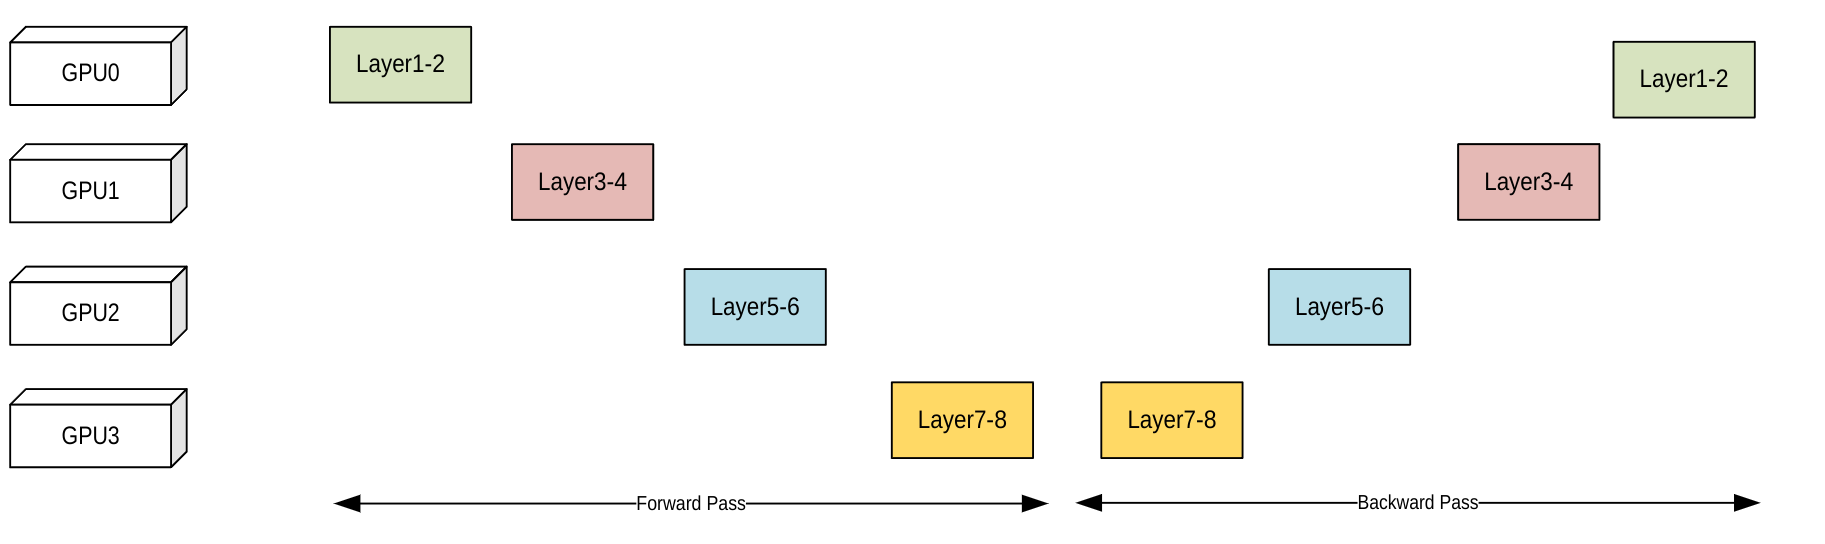

If model parameter is larger than gpu memory size, we could use model parallel training to spilt different layer's of model into different gpu. Forward intermeditate result between gpus. Each gpu is responsile for compute its local layes.

Here we spilt the model manually into 4 gpus.

```
class ModelParallelResNet9(ndl.nn.Module):
    """ResNet9 split across multiple GPUs"""

    def __init__(self, num_gpus, device=None, dtype="float32"):
        super().__init__()
        self.num_gpus = num_gpus
        self.comm = MPI.COMM_WORLD
        self.rank = self.comm.Get_rank()

        if self.rank == 0:
            # First GPU: Initial convolutions
            self.cb1 = ConvBN(3, 16, 7, 4, device=device, dtype=dtype)
            self.cb2 = ConvBN(16, 32, 3, 2, device=device, dtype=dtype)

        elif self.rank == 1:
            # Second GPU: First residual block
            self.cb3 = ConvBN(32, 32, 3, 1, device=device, dtype=dtype)
            self.cb4 = ConvBN(32, 32, 3, 1, device=device, dtype=dtype)

        elif self.rank == 2:
            # Third GPU: Second set of convolutions
            self.cb5 = ConvBN(32, 64, 3, 2, device=device, dtype=dtype)
            self.cb6 = ConvBN(64, 128, 3, 2, device=device, dtype=dtype)

        elif self.rank == 3:
            # Fourth GPU: Final residual block and classifier
            self.cb7 = ConvBN(128, 128, 3, 1, device=device, dtype=dtype)
            self.cb8 = ConvBN(128, 128, 3, 1, device=device, dtype=dtype)
            self.linear1 = ndl.nn.Linear(128, 128, device=device, dtype=dtype)
            self.relu = ndl.nn.ReLU()
            self.linear2 = ndl.nn.Linear(128, 10, device=device, dtype=dtype)
```

This is a small model and we just want to build a prototype of model parallel training.

In [ ]:
 mpirun -np 4 python train_model_parallel.py

### 4 GPU Model Parallelism
Use cuda: 2
Use cuda: 0
Use cuda: 1
Use cuda: 3
dataset length: 50000
dataset length: 50000
dataset length: 50000
dataset length: 50000
rank: 1, epoch: 1
rank: 2, epoch: 1
rank: 3, epoch: 1
rank: 0, epoch: 1
batch 0, acc: 0.1406, loss: 3.5602
batch 100, acc: 0.3359, loss: 1.7499
batch 200, acc: 0.3594, loss: 1.7220
batch 300, acc: 0.4062, loss: 1.6599
Training Time: 122.0033962726593


## 2.3 Data-Pipeline Model Parallel Traning

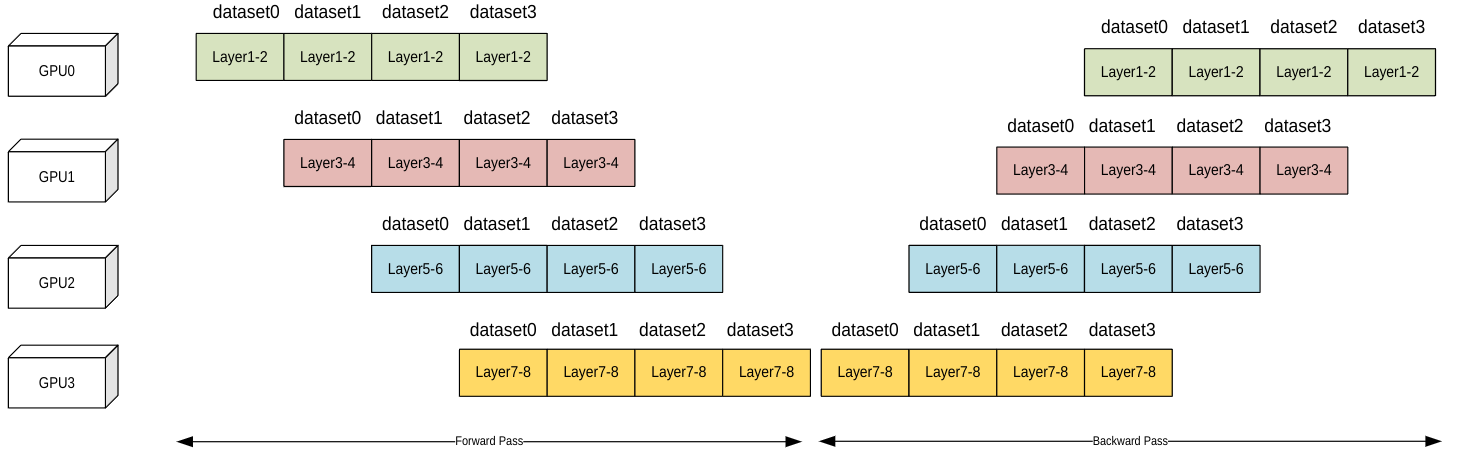

Pipeline parallelism divides the input mini-batch into smaller micro-batches.

In the example, we spilt data into 4 microbatches.

```
        # Manually split the data into microbatches using NumPy slicing
        microbatches_X = [ndl.Tensor(X_np[i * microbatch_size:(i + 1) * microbatch_size], device=device) for i in range(num_microbatches)]
        microbatches_y = [ndl.Tensor(y_np[i * microbatch_size:(i + 1) * microbatch_size], device=device) for i in range(num_microbatches)]

        # Handle any remaining data if batch_size is not perfectly divisible
        if batch_size % num_microbatches != 0:
            microbatches_X[-1] = ndl.Tensor(X_np[(num_microbatches - 1) * microbatch_size:], device=device)
            microbatches_y[-1] = ndl.Tensor(y_np[(num_microbatches - 1) * microbatch_size:], device=device)

        # Now microbatches_X and microbatches_y contain the split data
        # Each element in these lists corresponds to a microbatch
            
        # Dictionary to store outputs of the forward pass
        forward_outputs = {}

        # Forward pass loop
        for step in range(num_microbatches):
            X_mb = microbatches_X[step]
            out = model(X_mb)
            forward_outputs[step] = out  # Store the output with step as key

            out = forward_outputs.get(step)  # Retrieve the output for this step
            if out is not None:
                if rank == 3:
                    loss = loss_fn(out, microbatches_y[step])
                    loss.backward()
                    if (i*num_microbatches)% 100 == 0:
                        # Calculate accuracy
                        correct = np.sum(np.argmax(out.numpy(), axis=1) == microbatches_y[step].numpy())
                        acc = correct / microbatches_y[step].shape[0]
                        # Print metrics
                        print(f'Batch {i*num_microbatches}, Microbatch {step}, Acc: {acc:.4f}, Loss: {loss.numpy():.4f}')

                    model.backward(out.grad)
                else:
                    grad_output = ndl.Tensor(np.zeros_like(out.numpy()), device=device)
                    model.backward(grad_output)

                # Perform optimizer step for each microbatch
                opt.step()

        # Ensure optimizer step is called after all microbatches are processed
        comm.Barrier()
```

In [ ]:
mpirun -np 4 python train_pipe_parallel.py

### log
Use cuda: 1
Use cuda: 3
Use cuda: 2
Use cuda: 0
dataset length: 50000
dataset length: 50000
dataset length: 50000
dataset length: 50000
Batch 0, Microbatch 0, Acc: 0.1406, Loss: 3.5602
Batch 0, Microbatch 1, Acc: 0.1406, Loss: 3.4884
Batch 0, Microbatch 2, Acc: 0.1797, Loss: 2.9158
Batch 0, Microbatch 3, Acc: 0.1328, Loss: 2.8952
Batch 100, Microbatch 0, Acc: 0.3359, Loss: 1.7499
Batch 100, Microbatch 1, Acc: 0.3672, Loss: 1.8679
Batch 100, Microbatch 2, Acc: 0.3750, Loss: 1.8591
Batch 100, Microbatch 3, Acc: 0.3281, Loss: 1.7831
Batch 200, Microbatch 0, Acc: 0.3594, Loss: 1.7220
Batch 200, Microbatch 1, Acc: 0.3828, Loss: 1.7042
Batch 200, Microbatch 2, Acc: 0.4219, Loss: 1.6976
Batch 200, Microbatch 3, Acc: 0.4375, Loss: 1.4472
Batch 300, Microbatch 0, Acc: 0.4062, Loss: 1.6599
Batch 300, Microbatch 1, Acc: 0.4375, Loss: 1.5387
Batch 300, Microbatch 2, Acc: 0.4922, Loss: 1.5801
Batch 300, Microbatch 3, Acc: 0.5078, Loss: 1.4425
Training Time: 130.17066884040833

# 3 Decentralized ML

## 3.1 Design

Note: This is a very simplified version of decentralized machine learning. In practice, there are many more details to consider, such as security, privacy, and fault tolerance. 

Our decentralized ML includes two main components: (1) The Needle framework, which is a PyTorch-like ML framework, which supports both distributed training and decentralized computing. (2) The go-needle client, which is a client for the decentralized network.

User A uses the Needle framework to write the code of their computing tasks and submit the task to the decentralized network. 

User B uses the go-needle client to join the decentralized network to provide their computing resources. The tasks submitted by User A will be executed on User B's computing resources. And user B will get the reward once it finishes the task and the result is verified by the network.

![Overview](docs/imgs/dddml.png)

### 3.1.1 Needle Framework

The Needle framework converts users' code into a computational graph. The operators of the graph and the data are separated.
The data, which might be very large, is stored in the decentralized storage.
The computational graph encapsulates the graph into a transaction.
The transaction is submitted to the decentralized network.

An example of a transaction:
```json
{
    "submitter_address": "0x123abcd", // who submits the transaction
    "data":{                          // the data of the computational graph
        "weight1": "0x21321", // hash value of the data in the decentralized storage
        "weight2": "0xabcd2",
    },
    "ops":{          // the operators of the computational graph
        "op1":{
            "input1": "weight1",
            "input2": "weight2",
            "op": "matmul",
            "output1": "output1"
        }
    },
    "gas": 1000  // how much gas the submitter is willing to pay for the transaction
}
```

### 3.1.2 Go-needle Client

In the decentralized network, there are two types of nodes: the miner and the verifier. The miner is responsible for executing the transaction, i.e., perform the real computation. The verifier is responsible for verifying the result of the computation.
Once a miner finishes the computation, it will pack the result into a block and submit the block to the network. The verifier will verify the result and the miner will get the reward if the result is correct.
The network does not require how to result is computed, it only cares about whether the result is correct.
So miners could use any methods to compute the result, e.g. using GPU(s), TPU(s), etc.

An example of a block:
```json
{
    "miner": "0x123abcd", // the address of the miner
    "transactions":[ 
        {
            "tx_hash": "0x1234", // the hash value of the transaction
            "resutls": "0xabcd", // the hash value of the result, whch is stored in the decentralized storage
        }
    ],
    "parentHash": "0x1234", // the hash value of the parent block
}
```


### 3.1.3 Verify the result

**Algorithmic way**: Given a computational graph, use certain algorithms to verify the result. For example, if the computational graph is a sample matrix multiplication, we can use the Freivalds' algorithm to verify the result. The verification process should be much easier than the computation process.
1. A common matrix multiplication is runs in O(n^3) time complexity.
2. Freivalds' algorithm can verify the result in O(n^2) time complexity with a small probability of error.
3. We can use multiple verifiers to verify the result to reduce the probability of error further.

Problems: it might be difficult or even impossible to verify the result of more complex computation tasks.

**Challenging**: We can randomly issue some challenging tasks to a miner, which we know the result in advance. If the miner can solve the challenging task, we can trust the miner to solve the real task.
Problems: A malicious node might recognize the challenging task and solves the challenging task honestly but cheats on the real task.

**Vote**: A task can be computed by multiple miners. The result is considered correct if the majority of the miners have the same result. 
Problems: Waste of resources.

## 3.2 Demo

### 3.2.1 Setup the network

Create an account and start a Miner on your local machine:
```
For arm64:  IMG=hfzhang6/pouw-geth-client:miner-mac-m1
For amd64:  IMG=hfzhang6/pouw-geth-client:miner-amd64

docker pull $IMG
# Use the account address to start the miner
docker run -it --name account-generator --entrypoint=""  $IMG geth account new
```
This will output something like:
```
Your new account is locked with a password. Please give a password. Do not forget this password.
Password:
Repeat password:

Your new key was generated

Public address of the key:   0x2ed1D3e06f268Dd207dab9f3F452252348d0eb57
Path of the secret key file: /root/.ethereum/keystore/UTC--2024-12-14T08-01-18.629899881Z--2ed1d3e06f268dd207dab9f3f452252348d0eb57

- You can share your public address with anyone. Others need it to interact with you.
- You must NEVER share the secret key with anyone! The key controls access to your funds!
- You must BACKUP your key file! Without the key, it's impossible to access account funds!
- You must REMEMBER your password! Without the password, it's impossible to decrypt the key!
```
The public address is your account address. Use this address to start the miner:
```
docker run -it --name my-miner -p 8545:8545 -p 30303:30303  -e MINER_ADDRESS=0x2ed1D3e06f268Dd207dab9f3F452252348d0eb57 $IMG
```
The follow code use our `Needle` framework to submit a task to the decentralized network.
The task is simple, just calculate the result of a matrix multiplication.

### 3.2.2 Setup the Needle framework

In [29]:
# the address of the account
%env NEEDLE_ACCOUNT_ADDRESS=0xAa6aC6b973f88FDb92f742e97210F65492c53DF5
#USE_YOUR_OWN_KEY # the private key of the account
%env NEEDLE_ACCOUNT_PRIVATEKEY=REPLACE_WITH_YOUR_PRIVATE
 # the address of a node in the decentralized network
%env NEEDLE_NODE_ADDRESS=http://13.50.117.77:8545

env: NEEDLE_ACCOUNT_ADDRESS=0xAa6aC6b973f88FDb92f742e97210F65492c53DF5
env: NEEDLE_ACCOUNT_PRIVATEKEY=REPLACE_WITH_YOUR_PRIVATE
env: NEEDLE_NODE_ADDRESS=http://13.50.117.77:8545


In [20]:
# Check the balance of the account
import os
from web3 import Web3
w3 = Web3(Web3.HTTPProvider(os.getenv('NEEDLE_NODE_ADDRESS')))
w3.eth.get_balance(os.getenv('NEEDLE_ACCOUNT_ADDRESS'))

100000000000000000000

In [25]:
import sys
sys.path.append('./python')
sys.path.append('./apps')
import needle as ndl
from needle import backend_ndarray as nd

A=ndl.Tensor(nd.array([[1,2],[3,4]]),requires_grad=False)
B=ndl.Tensor(nd.array([[1,2,3,4],[3,4,5,6]]), requires_grad=False)
tx=ndl.ops.decentralized_matmul(A,B) # submit the task
print(tx.tx_hash.hex()) # print the transaction hash


0360046e8cf459b428950f84d3a0d8f53b5b9b70fe39756727a6b114b89edf13


The above task will be executed on a node in the network and the results can be retrieved querying the block.

In [26]:
print(tx.get_result())

[[ 7 10 13 16]
 [15 22 29 36]]


In [27]:
# Find the block that contains the transaction
num_block=w3.eth.get_block_number()
target_block=None
for i in range(num_block):
    block=w3.eth.get_block(i)
    if tx.tx_hash in block['transactions']:
        display(block)
        target_block=block
        break

AttributeDict({'difficulty': 159040,
 'extraData': HexBytes('0xd883010b06846765746888676f312e31392e34856c696e7578'),
 'gasLimit': 18080249,
 'gasUsed': 22564,
 'hash': HexBytes('0x118db7fed8bf5b8dcf4932cdf4288378e18b9d5c7e12312fbbd3136dc81d9366'),
 'logsBloom': HexBytes('0x00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000'),
 'miner': '0xB1d7B7110C1fD42EeBA71c89A2312F850c7861eb',
 'mixHash': HexBytes('0x0000000000000000000000000000000000000000000000000000000000000000'),
 'nonce': HexBytes('0x070a0d100f161d24'),
 'number': 420,
 'pa

In [28]:
# Check the balance of the miner
miner_address=target_block['miner']
miner_balance=w3.eth.get_balance(miner_address)
print("Miner balance: ",miner_balance)

# Check the balance of the submitter account
account_balance=w3.eth.get_balance(os.getenv('NEEDLE_ACCOUNT_ADDRESS'))
print("Submitter balance: ",account_balance)

Miner balance:  2000045128000000000
Submitter balance:  99999909744000000000


## 3.3 Other Considerations
1. Efficiency is a big problem in such a decentralized network. For the computational task with large size of parameters, a lot of time are needed to transfer the data between users, miners and the decentralized storage.
2. Privacy is another problem. The data of the computational graph might be sensitive and should be protected.
3. Centralization is also a problem. Complex tasks that require a lot of computing resources might can only be computed by a few miners, which is not decentralized.
4. Reward mechanism. The reward should be based on the computational complexity, such as FLOPs (floating-point operations) of the computation. The real time a miner spends on the computation should also be considered. A shorter time should get a higher reward. 
5. Economic consideration. The amount of the reward keeps increasing, which might lead to the inflation of the network, which decentivizes the miners to join the network and leads to the failure of the network.


# 4 Security of Decentralized ML

Refer to [PDF slides](decentralized_machine_learning.pdf)

# References

[1] Distributed training. https://learn.microsoft.com/en-us/azure/machine-learning/concept-distributed-training

[2] Data Parallelism VS Model Parallelism in Distributed Deep Learning Training. https://leimao.github.io/blog/Data-Parallelism-vs-Model-Paralelism/

[3] Horovod Framework: https://horovod.ai